In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import pickle
import math

from collections import OrderedDict, Counter
from copy import deepcopy

from Bio.PDB import PDBParser, ResidueDepth, PDBIO, Superimposer, Select
from Bio.SeqUtils import seq3
from Bio.PDB.vectors import calc_angle
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold, LeaveOneGroupOut, GroupKFold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, make_scorer, roc_auc_score, precision_recall_curve, auc, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from scipy.stats import pearsonr, sem

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from spl_function import *
from measure_function import *

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

kB = 1.9872036*(10**(-3))  # kcal mol^-1 K^-1

In [2]:
# ======================================
# Function we will use for scatter plots
# ======================================
def plot_corr(ax, x, y, xerr=None, yerr=None, xlim=[-5,+5], ylim=[-5,+5], title='', legendloc=None,
              fit=True, diagonal=True, labelsize=16, msize=90, yax=1.36, xax=1.36,
              colorbar=False, vmin=0.0, vmax=2.8, cbarlabel='cbar', cbar_shrink=1.0, cbar_pad=0.15):
  
    # the absolute error for each data point
    diff = np.abs(x-y)
    cmap = plt.cm.coolwarm
    
    SC = ax.scatter(x=x, y=y, c=diff, cmap=cmap, s=msize, edgecolors='k', linewidths=1.2, zorder=10, 
                vmin=0.0, vmax=2.8, label='_nolegend_')
    
    if yerr is None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, fmt=None, marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    elif yerr is not None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt='none', marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    
    # Make ColorBar
    if colorbar is True:
        cbarticks = [0.0, 0.7, 1.4, 2.1, 2.8]
        cbar = fig.colorbar(SC, ax=ax, shrink=cbar_shrink, pad=cbar_pad, ticks=cbarticks)
        cbar.set_label(cbarlabel, fontsize=labelsize)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=labelsize)
    
    # Ticks and labels
    ax.set_xlabel(r'Experimental $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
    ax.set_ylabel(r'Calculated $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
  
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    
    xmin = min(xlim)
    xmax = max(xlim)
    ymin = min(ylim)
    ymax = max(ylim)
    
    if title != '':
        ax.set_title(title, fontsize=labelsize*1.2)
    
    # add diagonal
    if diagonal is True:
        ax.plot([xmin,xmax], [xmin,xmax], '--', color='gray')

    # add zero axes
    ax.axvline(x=xax, color='k', linestyle='-', linewidth=1.2)
    ax.axhline(y=yax, color='k', linestyle='-', linewidth=1.2)
    
    # shaded area indicating 1,2 kcal/mol errors
    a = [xmin,xmax]
    b = [j+1.4 for j in a]
    c = [j-1.4 for j in a]
    ax.fill_between(a, b, c, alpha=0.1, interpolate=True, color='k')
    
    # Linear fit
    if fit is True:
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)
        x_fit = np.linspace(xmin, xmax, len(x)) 
        y_fit = fit_fn(x_fit)
        ax.plot(x_fit, y_fit, '-', color='k', zorder=1, 
                label='$\Delta\Delta G_{calc} = %.2f \cdot \Delta\Delta G_{exp} %+.2f$' %(fit[0],fit[1]))

    # grid
    ax.grid(b=True, which='major', color='0.5',linestyle=':')

    ax.set_xlim([xmax,xmin])
    ax.set_ylim([ymax,ymin])
    
    # Make box square
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(aspect=(x1-x0)/(y1-y0))
    
    # make legend
    if legendloc is not None:
        legend = ax.legend(loc=legendloc, prop={'size':labelsize*0.8})
        
        
# ====================
# Performance measures
# ====================
def get_rmse(x,y):
    return np.sqrt((np.mean((x-y)**2)))


def get_pearson(x,y):
    return pearsonr(x,y)[0]


def get_auc_roc(y,y_pred):
    true_bool = np.array([i > 0.0 for i in y])
    scores = np.array(y_pred)
    auc = roc_auc_score(true_bool, scores)
    return auc


def get_auc_prc(exp, calc):
    true_bool = np.array([x > 1.36 for x in exp]) # identify resistant mutations (ddG > 1.36 kcal/mol)
    scores = np.array(calc) # the scores are the calc ddg (higher ddg = higher probability of resistance)
    precision, recall, thresholds = precision_recall_curve(true_bool, scores)
    auc_score = auc(recall, precision)
    return auc_score

def get_mcc(exp, calc):
    true_bool = np.array([x > 1.36 for x in exp])      # identify resistant mutations (ddG > 1.36 kcal/mol)
    scores = np.array([x > 1.36 for x in calc])        # the scores are the calc ddg (higher ddg = higher probability of resistance)
    mcc = matthews_corrcoef(true_bool, scores)
   
    return mcc
    
# define additional sklearn scores
my_pearson = make_scorer(get_pearson, greater_is_better=True)
my_rmse = make_scorer(get_rmse, greater_is_better=False)
my_roc = make_scorer(get_auc_roc, greater_is_better=True)
my_prc = make_scorer(get_auc_prc, greater_is_better=True)
my_mcc = make_scorer(get_mcc, greater_is_better=True)

#### Load the TKI dataset with the features
____

In [3]:
tki = pd.read_csv("./Data/tki_total_features_ref15.csv") 

Y_tki = tki['LOGK_FOLDCHG']
todrop = ['PDB_ID', 'TKI','LIG_ID','SMILES','MUTATION','CHAIN','WT_IC50','LOGK_FOLDCHG', 
          'DDG.EXP','ligs', 'ligs3D', 'pdbs']
X_tki = tki.drop(todrop, axis=1)

pTest = deepcopy(tki[['PDB_ID', 'MUTATION']])

In [4]:
# lists to store predictions and exp data
xval_y_exp = []
xval_y_pred = []    

# ========
# run xval
# ========

for train_idx, test_idx in LeaveOneGroupOut().split(X=tki, groups=tki['TKI']):
    print('Testing on %s.' % tki.iloc[test_idx[0]]['TKI'])
    # --------------------------------------------
    # define inner cv to perform feature selection
    # --------------------------------------------
    tki_inner = tki.iloc[train_idx]
    X_tki_inner = X_tki.iloc[train_idx]
    Y_tki_inner = Y_tki.iloc[train_idx]
    innercv = LeaveOneGroupOut().split(X=tki_inner, groups=tki_inner['TKI'])
    
    select = ExtraTreesRegressor(n_estimators=200, max_depth = None, min_samples_split = 2, 
                                 bootstrap = True, oob_score = True, n_jobs = -1)
        
    # innercv will return only the entries for the 7 ligands used in the inner cv (excluding X_test)
    select.fit(X_tki_inner, Y_tki_inner)
    clf = SelectFromModel(select, prefit=True)
        
    # ----------------------------
    # test on 8th independent fold
    # ----------------------------
    X_train = clf.transform(X_tki.iloc[train_idx])  # select subset of features according to validation
    Y_train = Y_tki.iloc[train_idx].reset_index(drop=True)
    X_test = clf.transform(X_tki.iloc[test_idx])    # select subset of features according to validation
    Y_test = Y_tki.iloc[test_idx]
        
    tree = ExtraTreesRegressor(n_estimators=200, max_depth = None, min_samples_split = 2,
                               bootstrap = True, oob_score = True, n_jobs = -1)
    tree.fit(X_train, Y_train)
    y_pred = tree.predict(X_test)
        
    # store predicted and exp data
    xval_y_exp.extend(Y_test)
    xval_y_pred.extend(y_pred)

T = 300
xval_y_pred = kB*T*np.log(10**(np.array(xval_y_pred)))
xval_y_exp = kB*T*np.log(10**(np.array(xval_y_exp)))

pTest.loc[:, 'DDG.ML3'] = xval_y_pred
pTest.loc[:, 'DDG.EXP'] = xval_y_exp

RMSE = get_rmse(xval_y_exp, xval_y_pred)
Pears = pearsonr(xval_y_exp, xval_y_pred)[0]
PRC = get_auc_prc(xval_y_exp, xval_y_pred)
MCC = get_mcc(xval_y_exp, xval_y_pred)

print("----Prediction Performance----")
print("RMSE: %.2f" % RMSE, "\nPearson: %.2f" % Pears, "\nAUPRC: %.2f" % PRC, "\nMCC: %.2f" % MCC)

Testing on axitinib.
Testing on bosutinib.
Testing on dasatinib.
Testing on erlotinib.
Testing on gefitinib.
Testing on imatinib.
Testing on nilotinib.
Testing on ponatinib.
----Prediction Performance----
RMSE: 0.69 
Pearson: 0.56 
AUPRC: 0.43 
MCC: 0.20


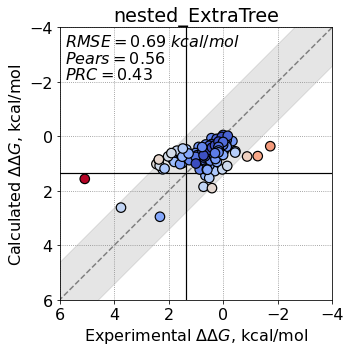

In [5]:
# ============
#    PLOT
# ============
T = 300
ddg_exp = pTest['DDG.EXP']
ddg_calc = pTest['DDG.ML3']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=False, sharey=False)

xlim = [-4, 6]
ylim = [-4, 6]

RMSE = get_rmse(ddg_exp, ddg_calc)
Pears = pearsonr(ddg_exp, ddg_calc)[0]
PRC = get_auc_prc(ddg_exp, ddg_calc)

plot_corr(ax, ddg_exp, ddg_calc, title='nested_ExtraTree', fit=False, xlim=xlim, ylim=ylim)

annx = 5.8
anny = -3.3
asep = -0.6
fs=16
_ = ax.annotate('$RMSE  = %.2f\ kcal/mol$' % (RMSE), xy=(annx, anny), zorder=10, fontsize=fs)
_ = ax.annotate('$Pears = %.2f$' % (Pears), xy=(annx, anny-asep), zorder=10, fontsize=fs)
_ = ax.annotate('$PRC   = %.2f$' % (PRC), xy=(annx, anny-2*asep), zorder=10, fontsize=fs)

# --------
# Fix look
# --------
ax.set_xticks([-4, -2, 0, 2, 4, 6])

plt.tight_layout()